In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import re
import string
from pandas_datareader import data as pdr
from datetime import datetime
import datetime as dt
import plotly.express as px
import yfinance as yfin
yfin.pdr_override()
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [ ]:
stock_data_sentiment = pd.read_csv("/content/drive/MyDrive/USP/8 Semestre/Redes Sociais - Digi/stock_data_sentiment.csv")
stock_data_sentiment

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [ ]:
def preprocessamento(texto):
  texto = texto.lower()
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", "", texto)
  texto = re.sub(r"https?://[A-Za-z0-9./]+", "", texto)
  texto = re.sub(r" +", " ", texto)
  return texto

In [ ]:
l = {
    -1:0,
    1:1
}

stock_data_sentiment['Sentiment'] = stock_data_sentiment['Sentiment'].map(l)
stock_data_sentiment

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [ ]:
stock_data_sentiment['Text'] = stock_data_sentiment['Text'].apply(preprocessamento)
stock_data_sentiment

,Text,Sentiment
0,kickers on my watchlist xide tit soq pnk cpw b...,1
1,user: aap movie. 55% return for the fea/geed i...,1
2,user i'd be afraid to short amzn - they are lo...,1
3,mnta over 12.00,1
4,oi over 21.37,1
...,...,...
5786,industry body cii said #discoms are likely to ...,0
5787,"#gold prices slip below rs 46,000 as #investor...",0
5788,workers at bajaj auto have agreed to a 10% wag...,1
5789,"#sharemarket live: sensex off day’s high, up 6...",1


<Axes: xlabel='Sentiment', ylabel='count'>

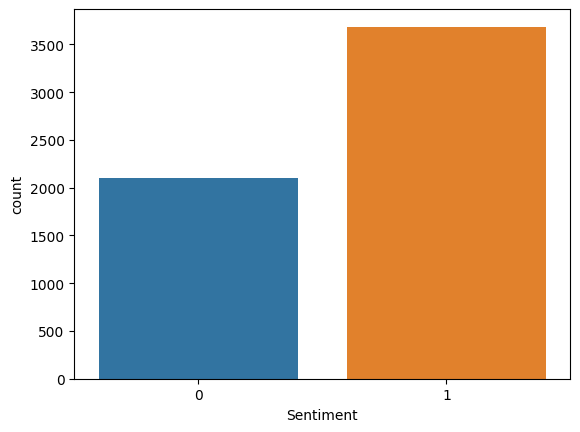

In [ ]:
#sns.countplot(titanic, x="class")
sns.countplot(stock_data_sentiment, x = 'Sentiment')

In [ ]:
stock_data_sentiment['Sentiment'].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [ ]:
#df['num_legs'].sample(n=3, random_state=1)
aux = stock_data_sentiment[stock_data_sentiment["Sentiment"] == 1].sample(n = 2106, random_state = 42)
#result = pd.concat([df1, df2])
stock_data_sentiment_balanceado = pd.concat([aux, stock_data_sentiment[stock_data_sentiment["Sentiment"] == 0]])
#df1 = df.sample(frac = 1)
stock_data_sentiment_balanceado = stock_data_sentiment_balanceado.sample(frac = 1)
stock_data_sentiment_balanceado

,Text,Sentiment
3781,mcp finally,1
311,"cs, kos positive.... nice reversal in kos",1
5155,prices for debt from companies including ford ...,1
2122,aap confirming nicely here above the 20 day of...,1
1919,ooks like those mcp 8 calls for friday are pay...,1
...,...,...
2921,opk broke out from its sideways consolidation ...,1
2024,"es,ec,jnk,dax is the s&p diverging from other...",0
1179,user i think the same aapl. iphone lost the wo...,0
4376,jcp = 2'nd biggest hustle on wall street. 2'nd...,0


<Axes: xlabel='Sentiment', ylabel='count'>

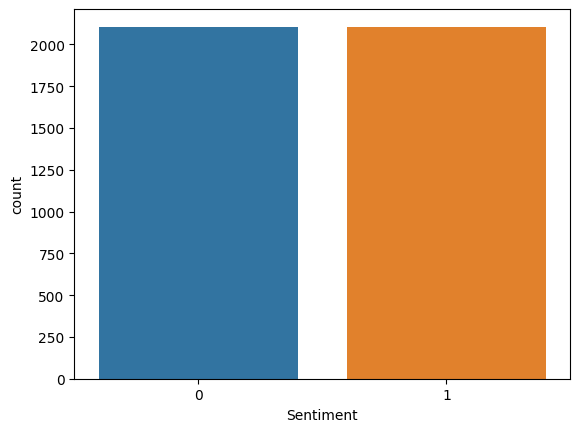

In [ ]:
sns.countplot(stock_data_sentiment_balanceado, x = 'Sentiment')

In [ ]:
from sklearn.model_selection import train_test_split

tuites_sentimentos_treinamento, tuites_sentimentos_teste = train_test_split(stock_data_sentiment_balanceado[["Text", "Sentiment"]], test_size = 0.3, stratify= stock_data_sentiment_balanceado[["Sentiment"]])
tuites_sentimentos_treinamento

,Text,Sentiment
2706,msft closed above its 200ema.short-term uptren...,1
5660,gold futures cool off after rising over 1% ami...,1
4089,np tap tap,0
3723,"sk 6.75 printed ah, this baby's gonna pop tomo...",1
1919,ooks like those mcp 8 calls for friday are pay...,1
...,...,...
37,here is new up target for aap and notice shake...,1
2227,cst about to go ed to geen watch break of 50da...,1
2534,54 short ideas to prepare for the next correct...,0
1194,"aap breaks low from 1/15. i'm just saying, eve...",0


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np

#configuracoes
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

print("### Etapa 1 - Carregar dados e organizar")

# carrega arquivo com as avaliacoes


print(stock_data_sentiment.info())
print(stock_data_sentiment.head())
print(stock_data_sentiment['Text'].head())
print(stock_data_sentiment['Sentiment'].head())

# Converte notas de 1 a 5 em 0 e 1
#def to_sentiment(rating):
#  rating = int(rating)
#  if rating <= 2:
#    return 0
#  else:
#    return 1

#sentimento_df['sentiment'] = sentimento_df.score.apply(to_sentiment)

# Organiza os dados em Treino e Teste
#training_size = 7000
#training_sentences = sentimento_df['content'].iloc[0:training_size].copy()
#testing_sentences = sentimento_df['content'].iloc[training_size:].copy()
training_sentences = tuites_sentimentos_teste["Text"]
testing_sentences = tuites_sentimentos_teste["Text"]

print(training_sentences.info())
print(training_sentences.head())

training_labels = tuites_sentimentos_teste["Sentiment"]
testing_labels = tuites_sentimentos_teste["Sentiment"]

print("### Etapa 2 - Converter palavras em numeros")
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

print("### Etapa 3 - Criar as frases/sequencias")
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequencias_treinamento = tokenizer.texts_to_sequences(training_sentences)
padded_treinamento = pad_sequences(sequencias_treinamento, maxlen=max_length, padding=padding_type, truncating=trunc_type)
sequencias_teste = tokenizer.texts_to_sequences(testing_sentences)
padded_teste = pad_sequences(sequencias_teste, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("### Etapa 4 - Criando a rede neural")
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(24, activation="relu"),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("### Etapa 5 - Treinando a rede")
num_epochs = 20
history = model.fit(padded_treinamento, training_labels, epochs=num_epochs,
                    validation_data=(padded_teste, testing_labels), verbose=2)

### Etapa 1 - Carregar dados e organizar
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB
None
                                                Text  Sentiment
0  kickers on my watchlist xide tit soq pnk cpw b...          1
1  user: aap movie. 55% return for the fea/geed i...          1
2  user i'd be afraid to short amzn - they are lo...          1
3                                   mnta over 12.00           1
4                                     oi over 21.37           1
0    kickers on my watchlist xide tit soq pnk cpw b...
1    user: aap movie. 55% return for the fea/geed i...
2    user i'd be afraid to short amzn - they are lo...
3                                     mnta over 12.00 
4                                    

In [ ]:
print("### Etapa 6 - Final - Testando com uma nova frase")

frases_avaliacao = ["aap - user if so then the current downtrend will break. otherwise just a short-term correction in med-term downtrend."]

sequencia = tokenizer.texts_to_sequences(frases_avaliacao)
padded = pad_sequences(sequencia, maxlen=max_length, padding=padding_type, truncating=trunc_type)

probs = model.predict(padded)

class_names = ['Negativo:', 'Positivo:']
for index, frase in enumerate(frases_avaliacao):
  print(class_names[round(probs[index][0])], probs[index], frase)

### Etapa 6 - Final - Testando com uma nova frase
1/1 [==============================] - 0s 69ms/step
Negativo: [0.03224641] aap - user if so then the current downtrend will break. otherwise just a short-term correction in med-term downtrend.


In [ ]:
tuites_empresas_2015_2020 = pd.read_csv("/content/drive/MyDrive/USP/8 Semestre/Redes Sociais - Digi/tuites_empresas_2015_2020.csv")
tuites_empresas_2015_2020

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,2015-01-01,AAPL
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,2015-01-01,AAPL
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,2015-01-01,AMZN
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,2015-01-01,TSLA
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,2015-01-01,AAPL
...,...,...,...,...,...,...,...,...,...
4336440,1212159838882533376,ShortingIsFun,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,0,0,1,2019-12-31,TSLA
4336441,1212160015332728833,Commuternyc,2019-12-31 23:54:03,Patiently Waiting for the no twitter sitter tw...,0,0,5,2019-12-31,TSLA
4336442,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,2019-12-31,AAPL
4336443,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,2019-12-31,MSFT


In [ ]:
tuites_empresas_2015 = tuites_empresas_2015_2020.query("post_date < '2015-03-01'")
tuites_empresas_2015['body'] = tuites_empresas_2015['body'].apply(preprocessamento)
tuites_empresas_2015

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $aapl -check it out! ?aff...",0,0,1,2015-01-01,AAPL
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling. $aap...,0,0,0,2015-01-01,AAPL
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,s&p100 #stocks performance $hd $low $sbux $tgt...,0,0,0,2015-01-01,AMZN
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,2015-01-01,TSLA
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,AAPL
...,...,...,...,...,...,...,...,...,...
140570,571820417960300545,NaN,2015-02-28 23:53:06,what #sector will you #invest in today? $tsla ...,0,0,1,2015-02-28,TSLA
140571,571820796605153281,MarketJolt,2015-02-28 23:54:36,get paid guaranteed cash at for each top predi...,0,0,0,2015-02-28,AAPL
140572,571821147525787648,MarketJolt,2015-02-28 23:56:00,earn cash for making stock predictions at prog...,0,0,0,2015-02-28,AMZN
140573,571821446042914817,larrysmiller,2015-02-28 23:57:11,"the brilliant on the four horsemen, and why ph...",0,0,1,2015-02-28,GOOG


Fazendo a análise de sentimento para cada um dos tuites:

In [ ]:
prob = []
for texto in tuites_empresas_2015['body']:

  frases_avaliacao = [texto]
  sequencia = tokenizer.texts_to_sequences(frases_avaliacao)
  padded = pad_sequences(sequencia, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  prob.append(model.predict(padded))

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 28ms/step


In [ ]:
classificacao = []
for i in range(len(prob)):
  classificacao.append(prob[i][0][0])

In [ ]:
tuites_empresas_2015["Classificacao_Keras"] = classificacao
tuites_empresas_2015

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol,Classificacao_Keras
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $aapl -check it out! ?aff...",0,0,1,2015-01-01,AAPL,0.600178
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling. $aap...,0,0,0,2015-01-01,AAPL,0.727493
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,s&p100 #stocks performance $hd $low $sbux $tgt...,0,0,0,2015-01-01,AMZN,0.101041
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,2015-01-01,TSLA,0.658379
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,AAPL,0.536182
...,...,...,...,...,...,...,...,...,...,...
140570,571820417960300545,NaN,2015-02-28 23:53:06,what #sector will you #invest in today? $tsla ...,0,0,1,2015-02-28,TSLA,0.687356
140571,571820796605153281,MarketJolt,2015-02-28 23:54:36,get paid guaranteed cash at for each top predi...,0,0,0,2015-02-28,AAPL,0.821912
140572,571821147525787648,MarketJolt,2015-02-28 23:56:00,earn cash for making stock predictions at prog...,0,0,0,2015-02-28,AMZN,0.781707
140573,571821446042914817,larrysmiller,2015-02-28 23:57:11,"the brilliant on the four horsemen, and why ph...",0,0,1,2015-02-28,GOOG,0.441956


In [ ]:
tuites_empresas_2015.to_csv('/content/drive/MyDrive/USP/8 Semestre/Redes Sociais - Digi/tuites_empresas_classificadas.csv')

In [ ]:
px.histogram(tuites_empresas_2015["Classificacao_Keras"])

In [ ]:
classes = []
for nota in tuites_empresas_2015["Classificacao_Keras"]:
  if nota >= 0.5:
    classes.append(1)
  #elif nota <= 0.4:
    #classes.append(-1)
  else:
    classes.append(-1)

tuites_empresas_2015["Classes_Sentimento"] = classes
tuites_empresas_2015

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol,Classificacao_Keras,Classes_Sentimento
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $aapl -check it out! ?aff...",0,0,1,2015-01-01,AAPL,0.600178,1
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling. $aap...,0,0,0,2015-01-01,AAPL,0.727493,1
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,s&p100 #stocks performance $hd $low $sbux $tgt...,0,0,0,2015-01-01,AMZN,0.101041,-1
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,2015-01-01,TSLA,0.658379,1
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,AAPL,0.536182,1
...,...,...,...,...,...,...,...,...,...,...,...
28542,555876657429352448,KymLang,2015-01-15 23:58:17,$amzn chart via,0,1,2,2015-01-15,AMZN,0.336439,-1
28543,555876735397273600,KymLang,2015-01-15 23:58:36,$googl chart via,0,0,0,2015-01-15,GOOGL,0.400698,-1
28544,555876866251169792,Chasing__Stars,2015-01-15 23:59:07,"$time stock price updated thursday, january 15...",0,0,0,2015-01-15,TSLA,0.771663,1
28545,555876879744266241,Chasing__Stars,2015-01-15 23:59:10,"$aphd recent news updated thursday, january 15...",0,0,0,2015-01-15,TSLA,0.628414,1


In [ ]:
#px.bar(data_frame=df, x="Name", y="counts", color="Defect severity", barmode="group")
px.histogram(tuites_empresas_2015["Classes_Sentimento"] )

In [ ]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2015, 1, 16)
lista_selecionadas = ["AAPL", "GOOG", "GOOGL", "AMZN", "AMZN", "TSLA", "MSFT"]
precos = pdr.get_data_yahoo(lista_selecionadas, inicio, final)['Adj Close']

RL_acoes = pd.DataFrame()
for empresa in precos.columns:
    RL_acoes[empresa] = np.log(precos[empresa]/precos[empresa].shift())
RL_acoes

[*********************100%%**********************]  6 of 6 completed


,AAPL,AMZN,GOOG,GOOGL,MSFT,TSLA
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.028576,-0.020731,-0.021066,-0.019238,-0.009238,-0.042950
2015-01-06,0.000094,-0.023098,-0.023450,-0.024989,-0.014786,0.005648
2015-01-07,0.013925,0.010544,-0.001715,-0.002945,0.012625,-0.001563
2015-01-08,0.037703,0.006813,0.003148,0.003478,0.028994,-0.001566
2015-01-09,0.001072,-0.011818,-0.013035,-0.012286,-0.008440,-0.018981
2015-01-12,-0.024949,-0.018765,-0.007323,-0.007336,-0.012582,-0.021768
2015-01-13,0.008839,0.011362,0.007343,0.009491,-0.005164,0.010038
2015-01-14,-0.003818,-0.005000,0.009408,0.008197,-0.008665,-0.058262


In [ ]:
for empresa in precos.columns:
    variacao = []
    for i in range(len(RL_acoes)):
        if(RL_acoes[empresa].iloc[i] > 0):
            variacao.append(f"POSITIVA")
        else:
            variacao.append(f"NEGATIVA")

    RL_acoes[f"VARIACAO_{empresa}"] = variacao
RL_acoes

,AAPL,AMZN,GOOG,GOOGL,MSFT,TSLA,VARIACAO_AAPL,VARIACAO_AMZN,VARIACAO_GOOG,VARIACAO_GOOGL,VARIACAO_MSFT,VARIACAO_TSLA
Date,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
2015-01-05,-0.028576,-0.020731,-0.021066,-0.019238,-0.009238,-0.042950,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
2015-01-06,0.000094,-0.023098,-0.023450,-0.024989,-0.014786,0.005648,POSITIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,POSITIVA
2015-01-07,0.013925,0.010544,-0.001715,-0.002945,0.012625,-0.001563,POSITIVA,POSITIVA,NEGATIVA,NEGATIVA,POSITIVA,NEGATIVA
2015-01-08,0.037703,0.006813,0.003148,0.003478,0.028994,-0.001566,POSITIVA,POSITIVA,POSITIVA,POSITIVA,POSITIVA,NEGATIVA
2015-01-09,0.001072,-0.011818,-0.013035,-0.012286,-0.008440,-0.018981,POSITIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
2015-01-12,-0.024949,-0.018765,-0.007323,-0.007336,-0.012582,-0.021768,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
2015-01-13,0.008839,0.011362,0.007343,0.009491,-0.005164,0.010038,POSITIVA,POSITIVA,POSITIVA,POSITIVA,NEGATIVA,POSITIVA
2015-01-14,-0.003818,-0.005000,0.009408,0.008197,-0.008665,-0.058262,NEGATIVA,NEGATIVA,POSITIVA,POSITIVA,NEGATIVA,NEGATIVA


In [ ]:
#sentimentos_dia["Data"] = pd.to_datetime(sentimentos_dia["Data"])
RL_acoes["Data"] = pd.to_datetime(RL_acoes.index)
RL_acoes

,AAPL,AMZN,GOOG,GOOGL,MSFT,TSLA,VARIACAO_AAPL,VARIACAO_AMZN,VARIACAO_GOOG,VARIACAO_GOOGL,VARIACAO_MSFT,VARIACAO_TSLA,Data
Date,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,2015-01-02
2015-01-05,-0.028576,-0.020731,-0.021066,-0.019238,-0.009238,-0.042950,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,2015-01-05
2015-01-06,0.000094,-0.023098,-0.023450,-0.024989,-0.014786,0.005648,POSITIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,POSITIVA,2015-01-06
2015-01-07,0.013925,0.010544,-0.001715,-0.002945,0.012625,-0.001563,POSITIVA,POSITIVA,NEGATIVA,NEGATIVA,POSITIVA,NEGATIVA,2015-01-07
2015-01-08,0.037703,0.006813,0.003148,0.003478,0.028994,-0.001566,POSITIVA,POSITIVA,POSITIVA,POSITIVA,POSITIVA,NEGATIVA,2015-01-08
2015-01-09,0.001072,-0.011818,-0.013035,-0.012286,-0.008440,-0.018981,POSITIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,2015-01-09
2015-01-12,-0.024949,-0.018765,-0.007323,-0.007336,-0.012582,-0.021768,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA,2015-01-12
2015-01-13,0.008839,0.011362,0.007343,0.009491,-0.005164,0.010038,POSITIVA,POSITIVA,POSITIVA,POSITIVA,NEGATIVA,POSITIVA,2015-01-13
2015-01-14,-0.003818,-0.005000,0.009408,0.008197,-0.008665,-0.058262,NEGATIVA,NEGATIVA,POSITIVA,POSITIVA,NEGATIVA,NEGATIVA,2015-01-14


In [ ]:
dias_necessarios = []
for i in range(len(RL_acoes["Data"].dt.day)):
  dias_necessarios.append(RL_acoes["Data"].dt.day[i] - 1)
dias_necessarios

[1, 4, 5, 6, 7, 8, 11, 12, 13, 14]

# Analise Amazon

In [ ]:
tuites_empresas_2015_AMZN = tuites_empresas_2015.query("ticker_symbol == 'AMZN'")
tuites_empresas_2015_AMZN

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol,Classificacao_Keras,Classes_Sentimento
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,s&p100 #stocks performance $hd $low $sbux $tgt...,0,0,0,2015-01-01,AMZN,0.101041,-1
27,550447850857828352,JorelLaraKalel,2015-01-01 00:26:09,top 10 searched #stocks of #2014 $aapl $fb $ba...,0,0,2,2015-01-01,AMZN,0.746497,1
37,550453172096217088,jakubhajost,2015-01-01 00:47:17,rt a look at blackberry's deals and acquisitio...,0,0,0,2015-01-01,AMZN,0.734552,1
38,550453624258965505,WSJ,2015-01-01 00:49:05,jeff bezos lost $7.4 billion in amazon's worst...,21,139,57,2015-01-01,AMZN,0.168178,-1
39,550453897714995200,GillesKLEIN,2015-01-01 00:50:10,jeff bezos lost $7.4 billion in #amazon worst ...,1,2,1,2015-01-01,AMZN,0.110105,-1
...,...,...,...,...,...,...,...,...,...,...,...
28489,555871025783529472,Bolsacash,2015-01-15 23:35:54,this i don't like!!! $amzn,0,0,1,2015-01-15,AMZN,0.301977,-1
28497,555871976095367168,10Xtrading,2015-01-15 23:39:41,t3 live daily recap: you change when the setup...,0,1,1,2015-01-15,AMZN,0.492501,-1
28514,555872389108477953,rosnerstocks,2015-01-15 23:41:19,"$svxy reviews updated thursday, january 15, 20...",0,0,1,2015-01-15,AMZN,0.608810,1
28520,555874321235587072,jdgreenfield,2015-01-15 23:49:00,could not be more excited for debate on $amzn....,0,0,3,2015-01-15,AMZN,0.301215,-1


In [ ]:
px.histogram(tuites_empresas_2015_AMZN["Classificacao_Keras"])

In [ ]:
px.histogram(tuites_empresas_2015_AMZN["Classes_Sentimento"] )

In [ ]:
classificacao_simples = []
soma = []
classificacao_likes = []
classificacao_retuites = []
classificacao_comentarios = []
for data in tuites_empresas_2015_AMZN["date"].unique():
  soma_simples = np.sum(tuites_empresas_2015_AMZN[tuites_empresas_2015_AMZN["date"] == data]['Classes_Sentimento'])
  soma.append(soma_simples)
  if soma_simples >= 0:
    classificacao_simples.append("POSITIVA")
  else:
    classificacao_simples.append("NEGATIVA")

  soma_likes = np.sum(tuites_empresas_2015_AMZN[tuites_empresas_2015_AMZN["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_AMZN[tuites_empresas_2015_AMZN["date"] == data]['like_num'] + 1))
  if soma_likes >= 0:
    classificacao_likes.append("POSITIVA")
  else:
    classificacao_likes.append("NEGATIVA")

  soma_retuites = np.sum(tuites_empresas_2015_AMZN[tuites_empresas_2015_AMZN["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_AMZN[tuites_empresas_2015_AMZN["date"] == data]['retweet_num'] + 1))
  if soma_retuites >= 0:
    classificacao_retuites.append("POSITIVA")
  else:
    classificacao_retuites.append("NEGATIVA")

  soma_comentarios = np.sum(tuites_empresas_2015_AMZN[tuites_empresas_2015_AMZN["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_AMZN[tuites_empresas_2015_AMZN["date"] == data]['comment_num'] + 1))
  if soma_comentarios >= 0:
    classificacao_comentarios.append("POSITIVA")
  else:
    classificacao_comentarios.append("NEGATIVA")


In [ ]:
#sentimentos_dia = pd.DataFrame({"Data":data,"Classificacao_Simples":classificacao_dia, "Classificacao_Likes":classificacao_dia_likes, "Classificacao_Retuite":classificacao_dia_retuites})
sentimentos_dia = pd.DataFrame({"Data":tuites_empresas_2015_AMZN["date"].unique() ,"Classificacao_Simples":classificacao_simples,
                                "Classificacao_Likes":classificacao_likes, "Classificacao_Retuite":classificacao_retuites,
                                "Classificacao_Comentarios":classificacao_comentarios})
sentimentos_dia["Data"] = pd.to_datetime(sentimentos_dia["Data"])
sentimentos_dia


,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
1,2015-01-02,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
2,2015-01-03,NEGATIVA,NEGATIVA,POSITIVA,NEGATIVA
3,2015-01-04,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
4,2015-01-05,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
5,2015-01-06,POSITIVA,POSITIVA,POSITIVA,POSITIVA
6,2015-01-07,POSITIVA,POSITIVA,NEGATIVA,POSITIVA
7,2015-01-08,POSITIVA,POSITIVA,POSITIVA,NEGATIVA
8,2015-01-09,POSITIVA,POSITIVA,POSITIVA,POSITIVA
9,2015-01-10,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA


In [ ]:
sentimentos_dia_necessarios = sentimentos_dia[sentimentos_dia["Data"].dt.day.isin(dias_necessarios)]
sentimentos_dia_necessarios

,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
3,2015-01-04,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
4,2015-01-05,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
5,2015-01-06,POSITIVA,POSITIVA,POSITIVA,POSITIVA
6,2015-01-07,POSITIVA,POSITIVA,NEGATIVA,POSITIVA
7,2015-01-08,POSITIVA,POSITIVA,POSITIVA,NEGATIVA
10,2015-01-11,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
11,2015-01-12,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
12,2015-01-13,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
13,2015-01-14,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA


In [ ]:
Movimentacao_Classificacao_Simples_acuracia = 0
Movimentacao_Classificacao_Likes_acuracia = 0
Movimentacao_Classificacao_Retuite_acuracia = 0
Movimentacao_Classificacao_Comentarios_acuracia = 0
for i in range(1, len(sentimentos_dia_necessarios), 1):
  if RL_acoes["VARIACAO_AMZN"][i] == sentimentos_dia_necessarios["Classificacao_Simples"].iloc[i]:
    Movimentacao_Classificacao_Simples_acuracia += 1
  if RL_acoes["VARIACAO_AMZN"][i] == sentimentos_dia_necessarios["Classificacao_Likes"].iloc[i]:
    Movimentacao_Classificacao_Likes_acuracia += 1
  if RL_acoes["VARIACAO_AMZN"][i] == sentimentos_dia_necessarios["Classificacao_Retuite"].iloc[i]:
    Movimentacao_Classificacao_Retuite_acuracia += 1
  if RL_acoes["VARIACAO_AMZN"][i] == sentimentos_dia_necessarios["Classificacao_Comentarios"].iloc[i]:
    Movimentacao_Classificacao_Comentarios_acuracia += 1

Simples_acuracia = Movimentacao_Classificacao_Simples_acuracia/len(sentimentos_dia_necessarios)
Likes_acuracia = Movimentacao_Classificacao_Likes_acuracia/len(sentimentos_dia_necessarios)
Retuite_acuracia = Movimentacao_Classificacao_Retuite_acuracia/len(sentimentos_dia_necessarios)
Comentarios_acuracia = Movimentacao_Classificacao_Comentarios_acuracia/len(sentimentos_dia_necessarios)
print(Simples_acuracia, " ", Likes_acuracia, " ", Retuite_acuracia, " ", Comentarios_acuracia)

0.7   0.7   0.6   0.8


# Analise APPLE

In [ ]:
tuites_empresas_2015_APPLE = tuites_empresas_2015.query("ticker_symbol == 'AAPL'")
tuites_empresas_2015_APPLE

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol,Classificacao_Keras,Classes_Sentimento
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $aapl -check it out! ?aff...",0,0,1,2015-01-01,AAPL,0.600178,1
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling. $aap...,0,0,0,2015-01-01,AAPL,0.727493,1
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,AAPL,0.536182,1
6,550443808606126081,aaplstocknews,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,AAPL,0.536182,1
8,550443809700851716,iknowfirst,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,AAPL,0.536182,1
...,...,...,...,...,...,...,...,...,...,...,...
28528,555875247702814721,_CardiacKid,2015-01-15 23:52:41,$aapl - silicon valley firms agree to pay $415...,0,0,1,2015-01-15,AAPL,0.162335,-1
28529,555875255843954690,corrbheinn,2015-01-15 23:52:43,$aapl - silicon valley firms agree to pay $415...,0,0,0,2015-01-15,AAPL,0.150865,-1
28536,555875565178081281,IMGFunding,2015-01-15 23:53:57,a 'tattoo' may end finger pricks for diabetics...,0,0,1,2015-01-15,AAPL,0.274580,-1
28540,555875906472779779,rexy8319,2015-01-15 23:55:18,what do you make of the plethora of wedges an...,1,0,1,2015-01-15,AAPL,0.617509,1


In [ ]:
px.histogram(tuites_empresas_2015_APPLE["Classificacao_Keras"])

In [ ]:
px.histogram(tuites_empresas_2015_APPLE["Classes_Sentimento"] )

In [ ]:
classificacao_simples = []
soma = []
classificacao_likes = []
classificacao_retuites = []
classificacao_comentarios = []
for data in tuites_empresas_2015_APPLE["date"].unique():
  soma_simples = np.sum(tuites_empresas_2015_APPLE[tuites_empresas_2015_APPLE["date"] == data]['Classes_Sentimento'])
  soma.append(soma_simples)
  if soma_simples >= 0:
    classificacao_simples.append("POSITIVA")
  else:
    classificacao_simples.append("NEGATIVA")

  soma_likes = np.sum(tuites_empresas_2015_APPLE[tuites_empresas_2015_APPLE["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_APPLE[tuites_empresas_2015_APPLE["date"] == data]['like_num'] + 1))
  if soma_likes >= 0:
    classificacao_likes.append("POSITIVA")
  else:
    classificacao_likes.append("NEGATIVA")

  soma_retuites = np.sum(tuites_empresas_2015_APPLE[tuites_empresas_2015_APPLE["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_APPLE[tuites_empresas_2015_APPLE["date"] == data]['retweet_num'] + 1))
  if soma_retuites >= 0:
    classificacao_retuites.append("POSITIVA")
  else:
    classificacao_retuites.append("NEGATIVA")

  soma_comentarios = np.sum(tuites_empresas_2015_APPLE[tuites_empresas_2015_APPLE["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_APPLE[tuites_empresas_2015_APPLE["date"] == data]['comment_num'] + 1))
  if soma_comentarios >= 0:
    classificacao_comentarios.append("POSITIVA")
  else:
    classificacao_comentarios.append("NEGATIVA")


In [ ]:
soma

[-85,
 -111,
 -192,
 -152,
 -393,
 -258,
 -382,
 -235,
 -176,
 -71,
 -86,
 -322,
 -328,
 -233,
 -228]

In [ ]:
#sentimentos_dia = pd.DataFrame({"Data":data,"Classificacao_Simples":classificacao_dia, "Classificacao_Likes":classificacao_dia_likes, "Classificacao_Retuite":classificacao_dia_retuites})
sentimentos_dia = pd.DataFrame({"Data":tuites_empresas_2015_APPLE["date"].unique() ,"Classificacao_Simples":classificacao_simples,
                                "Classificacao_Likes":classificacao_likes, "Classificacao_Retuite":classificacao_retuites,
                                "Classificacao_Comentarios":classificacao_comentarios})
sentimentos_dia["Data"] = pd.to_datetime(sentimentos_dia["Data"])
sentimentos_dia


,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
1,2015-01-02,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
2,2015-01-03,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
3,2015-01-04,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
4,2015-01-05,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
5,2015-01-06,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
6,2015-01-07,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
7,2015-01-08,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
8,2015-01-09,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
9,2015-01-10,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA


In [ ]:
sentimentos_dia_necessarios = sentimentos_dia[sentimentos_dia["Data"].dt.day.isin(dias_necessarios)]
sentimentos_dia_necessarios

,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
3,2015-01-04,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
4,2015-01-05,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
5,2015-01-06,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
6,2015-01-07,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
7,2015-01-08,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
10,2015-01-11,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
11,2015-01-12,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
12,2015-01-13,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
13,2015-01-14,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA


In [ ]:
Movimentacao_Classificacao_Simples_acuracia = 0
Movimentacao_Classificacao_Likes_acuracia = 0
Movimentacao_Classificacao_Retuite_acuracia = 0
Movimentacao_Classificacao_Comentarios_acuracia = 0
for i in range(1, len(sentimentos_dia_necessarios), 1):
  if RL_acoes["VARIACAO_AAPL"][i] == sentimentos_dia_necessarios["Classificacao_Simples"].iloc[i]:
    Movimentacao_Classificacao_Simples_acuracia += 1
  if RL_acoes["VARIACAO_AAPL"][i] == sentimentos_dia_necessarios["Classificacao_Likes"].iloc[i]:
    Movimentacao_Classificacao_Likes_acuracia += 1
  if RL_acoes["VARIACAO_AAPL"][i] == sentimentos_dia_necessarios["Classificacao_Retuite"].iloc[i]:
    Movimentacao_Classificacao_Retuite_acuracia += 1
  if RL_acoes["VARIACAO_AAPL"][i] == sentimentos_dia_necessarios["Classificacao_Comentarios"].iloc[i]:
    Movimentacao_Classificacao_Comentarios_acuracia += 1

Simples_acuracia = Movimentacao_Classificacao_Simples_acuracia/len(sentimentos_dia_necessarios)
Likes_acuracia = Movimentacao_Classificacao_Likes_acuracia/len(sentimentos_dia_necessarios)
Retuite_acuracia = Movimentacao_Classificacao_Retuite_acuracia/len(sentimentos_dia_necessarios)
Comentarios_acuracia = Movimentacao_Classificacao_Comentarios_acuracia/len(sentimentos_dia_necessarios)
print(Simples_acuracia, " ", Likes_acuracia, " ", Retuite_acuracia, " ", Comentarios_acuracia)

0.4   0.4   0.4   0.4


# Analise GOOGLE

In [ ]:
tuites_empresas_2015_GOOGLE = tuites_empresas_2015.query("ticker_symbol == 'GOOGL'")
tuites_empresas_2015_GOOGLE

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol,Classificacao_Keras,Classes_Sentimento
30,550447998577426433,UPBOptionMil,2015-01-01 00:26:44,2014 the year in review (part ii - the end) -o...,0,2,2,2015-01-01,GOOGL,0.211184,-1
59,550461555423584257,t_nathan95,2015-01-01 01:20:36,prediction: $twtr $grpn $yelp are acquired as ...,0,0,1,2015-01-01,GOOGL,0.632526,1
62,550462670353494016,t_nathan95,2015-01-01 01:25:02,prediction: paypal post-spinoff and $pay are n...,0,0,0,2015-01-01,GOOGL,0.478211,-1
72,550466497655877633,PBratbyOfficial,2015-01-01 01:40:14,trailing stop taken out on my $googl #trade ta...,0,0,0,2015-01-01,GOOGL,0.910886,1
87,550471417754845184,SentiQuant,2015-01-01 01:59:47,#sentishiftup $x $t $googl $amrn $upip $cnat $...,0,0,0,2015-01-01,GOOGL,0.629243,1
...,...,...,...,...,...,...,...,...,...,...,...
28531,555875299468902403,NASDAQODUK,2015-01-15 23:52:53,$googl - silicon valley firms agree to pay $41...,0,0,0,2015-01-15,GOOGL,0.195086,-1
28534,555875562032353281,ChartPlay,2015-01-15 23:53:56,$googl chart: inverse h&s .,0,0,0,2015-01-15,GOOGL,0.288501,-1
28535,555875562510491649,TV_TradingIdeas,2015-01-15 23:53:56,inverse h&s $googl,0,0,0,2015-01-15,GOOGL,0.287374,-1
28539,555875814445572097,Shanks604,2015-01-15 23:54:56,these fucking assholes are gonna gap $googl b...,0,0,0,2015-01-15,GOOGL,0.165637,-1


In [ ]:
px.histogram(tuites_empresas_2015_GOOGLE["Classificacao_Keras"])

In [ ]:
px.histogram(tuites_empresas_2015_GOOGLE["Classes_Sentimento"] )

In [ ]:
classificacao_simples = []
soma = []
classificacao_likes = []
classificacao_retuites = []
classificacao_comentarios = []
for data in tuites_empresas_2015_GOOGLE["date"].unique():
  soma_simples = np.sum(tuites_empresas_2015_GOOGLE[tuites_empresas_2015_GOOGLE["date"] == data]['Classes_Sentimento'])
  soma.append(soma_simples)
  if soma_simples >= 0:
    classificacao_simples.append("POSITIVA")
  else:
    classificacao_simples.append("NEGATIVA")

  soma_likes = np.sum(tuites_empresas_2015_GOOGLE[tuites_empresas_2015_GOOGLE["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_GOOGLE[tuites_empresas_2015_GOOGLE["date"] == data]['like_num'] + 1))
  if soma_likes >= 0:
    classificacao_likes.append("POSITIVA")
  else:
    classificacao_likes.append("NEGATIVA")

  soma_retuites = np.sum(tuites_empresas_2015_GOOGLE[tuites_empresas_2015_GOOGLE["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_GOOGLE[tuites_empresas_2015_GOOGLE["date"] == data]['retweet_num'] + 1))
  if soma_retuites >= 0:
    classificacao_retuites.append("POSITIVA")
  else:
    classificacao_retuites.append("NEGATIVA")

  soma_comentarios = np.sum(tuites_empresas_2015_GOOGLE[tuites_empresas_2015_GOOGLE["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_GOOGLE[tuites_empresas_2015_GOOGLE["date"] == data]['comment_num'] + 1))
  if soma_comentarios >= 0:
    classificacao_comentarios.append("POSITIVA")
  else:
    classificacao_comentarios.append("NEGATIVA")


In [ ]:
soma

[-13, 7, -110, -112, -107, -109, -134, -89, -24, -16, -29, -60, 5, 58, 7]

In [ ]:
#sentimentos_dia = pd.DataFrame({"Data":data,"Classificacao_Simples":classificacao_dia, "Classificacao_Likes":classificacao_dia_likes, "Classificacao_Retuite":classificacao_dia_retuites})
sentimentos_dia = pd.DataFrame({"Data":tuites_empresas_2015_GOOGLE["date"].unique() ,"Classificacao_Simples":classificacao_simples,
                                "Classificacao_Likes":classificacao_likes, "Classificacao_Retuite":classificacao_retuites,
                                "Classificacao_Comentarios":classificacao_comentarios})
sentimentos_dia["Data"] = pd.to_datetime(sentimentos_dia["Data"])
sentimentos_dia


,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
1,2015-01-02,POSITIVA,POSITIVA,POSITIVA,POSITIVA
2,2015-01-03,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
3,2015-01-04,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
4,2015-01-05,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
5,2015-01-06,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
6,2015-01-07,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
7,2015-01-08,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
8,2015-01-09,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
9,2015-01-10,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA


In [ ]:
sentimentos_dia_necessarios = sentimentos_dia[sentimentos_dia["Data"].dt.day.isin(dias_necessarios)]
sentimentos_dia_necessarios

,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
3,2015-01-04,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
4,2015-01-05,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
5,2015-01-06,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
6,2015-01-07,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
7,2015-01-08,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
10,2015-01-11,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
11,2015-01-12,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
12,2015-01-13,POSITIVA,NEGATIVA,NEGATIVA,POSITIVA
13,2015-01-14,POSITIVA,POSITIVA,POSITIVA,POSITIVA


In [ ]:
Movimentacao_Classificacao_Simples_acuracia = 0
Movimentacao_Classificacao_Likes_acuracia = 0
Movimentacao_Classificacao_Retuite_acuracia = 0
Movimentacao_Classificacao_Comentarios_acuracia = 0
for i in range(1, len(sentimentos_dia_necessarios), 1):
  if RL_acoes["VARIACAO_GOOGL"][i] == sentimentos_dia_necessarios["Classificacao_Simples"].iloc[i]:
    Movimentacao_Classificacao_Simples_acuracia += 1
  if RL_acoes["VARIACAO_GOOGL"][i] == sentimentos_dia_necessarios["Classificacao_Likes"].iloc[i]:
    Movimentacao_Classificacao_Likes_acuracia += 1
  if RL_acoes["VARIACAO_GOOGL"][i] == sentimentos_dia_necessarios["Classificacao_Retuite"].iloc[i]:
    Movimentacao_Classificacao_Retuite_acuracia += 1
  if RL_acoes["VARIACAO_GOOGL"][i] == sentimentos_dia_necessarios["Classificacao_Comentarios"].iloc[i]:
    Movimentacao_Classificacao_Comentarios_acuracia += 1

Simples_acuracia = Movimentacao_Classificacao_Simples_acuracia/len(sentimentos_dia_necessarios)
Likes_acuracia = Movimentacao_Classificacao_Likes_acuracia/len(sentimentos_dia_necessarios)
Retuite_acuracia = Movimentacao_Classificacao_Retuite_acuracia/len(sentimentos_dia_necessarios)
Comentarios_acuracia = Movimentacao_Classificacao_Comentarios_acuracia/len(sentimentos_dia_necessarios)
print(Simples_acuracia, " ", Likes_acuracia, " ", Retuite_acuracia, " ", Comentarios_acuracia)

0.6   0.5   0.5   0.6


# Analise Microsoft

In [ ]:
tuites_empresas_2015_MSFT = tuites_empresas_2015.query("ticker_symbol == 'MSFT'")
tuites_empresas_2015_MSFT

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol,Classificacao_Keras,Classes_Sentimento
19,550444112328261632,GetAOM,2015-01-01 00:11:17,$unp $orcl $qcom $msft $aapl top scoring mega ...,0,0,0,2015-01-01,MSFT,0.400875,-1
43,550455355134578688,BoilerWarrior,2015-01-01 00:55:58,"penny stocks, nyse, and nasdaq trades from th...",0,0,0,2015-01-01,MSFT,0.657414,1
46,550455384734183424,StocksThatDoubl,2015-01-01 00:56:05,want alerts for momentum stocks about to run? ...,0,0,0,2015-01-01,MSFT,0.821851,1
75,550466945061908482,The_Dumb_Money,2015-01-01 01:42:01,"imho, $msft shockingly remains mildly undervalued",1,0,0,2015-01-01,MSFT,0.614414,1
82,550468859879505921,UnderGradStocks,2015-01-01 01:49:38,i like $msft with him in charge. he seems to ...,0,0,0,2015-01-01,MSFT,0.113169,-1
...,...,...,...,...,...,...,...,...,...,...,...
28410,555853747080138754,Tech_Blend,2015-01-15 22:27:15,"resetting the score, says // comparison of the...",0,0,0,2015-01-15,MSFT,0.656375,1
28424,555855283881533440,MarketsRecap,2015-01-15 22:33:21,technicals on the 5 most popular stocks $aapl ...,0,0,0,2015-01-15,MSFT,0.910040,1
28436,555857568329785344,johnshinal,2015-01-15 22:42:26,"intel ceo on conference call: ""our view of pc ...",0,0,0,2015-01-15,MSFT,0.943887,1
28457,555863449730048001,Stockaholics,2015-01-15 23:05:48,our picks on $ijjp and $tung saw powerful move...,0,0,0,2015-01-15,MSFT,0.365135,-1


In [ ]:
px.histogram(tuites_empresas_2015_MSFT["Classificacao_Keras"])

In [ ]:
px.histogram(tuites_empresas_2015_MSFT["Classes_Sentimento"] )

In [ ]:
classificacao_simples = []
soma = []
classificacao_likes = []
classificacao_retuites = []
classificacao_comentarios = []
for data in tuites_empresas_2015_MSFT["date"].unique():
  soma_simples = np.sum(tuites_empresas_2015_MSFT[tuites_empresas_2015_MSFT["date"] == data]['Classes_Sentimento'])
  soma.append(soma_simples)
  if soma_simples >= 0:
    classificacao_simples.append("POSITIVA")
  else:
    classificacao_simples.append("NEGATIVA")

  soma_likes = np.sum(tuites_empresas_2015_MSFT[tuites_empresas_2015_MSFT["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_MSFT[tuites_empresas_2015_MSFT["date"] == data]['like_num'] + 1))
  if soma_likes >= 0:
    classificacao_likes.append("POSITIVA")
  else:
    classificacao_likes.append("NEGATIVA")

  soma_retuites = np.sum(tuites_empresas_2015_MSFT[tuites_empresas_2015_MSFT["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_MSFT[tuites_empresas_2015_MSFT["date"] == data]['retweet_num'] + 1))
  if soma_retuites >= 0:
    classificacao_retuites.append("POSITIVA")
  else:
    classificacao_retuites.append("NEGATIVA")

  soma_comentarios = np.sum(tuites_empresas_2015_MSFT[tuites_empresas_2015_MSFT["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_MSFT[tuites_empresas_2015_MSFT["date"] == data]['comment_num'] + 1))
  if soma_comentarios >= 0:
    classificacao_comentarios.append("POSITIVA")
  else:
    classificacao_comentarios.append("NEGATIVA")


In [ ]:
soma

[8, 31, 11, 16, 16, 36, 26, 54, 27, 15, 8, 23, 34, 57, 37]

In [ ]:
#sentimentos_dia = pd.DataFrame({"Data":data,"Classificacao_Simples":classificacao_dia, "Classificacao_Likes":classificacao_dia_likes, "Classificacao_Retuite":classificacao_dia_retuites})
sentimentos_dia = pd.DataFrame({"Data":tuites_empresas_2015_MSFT["date"].unique() ,"Classificacao_Simples":classificacao_simples,
                                "Classificacao_Likes":classificacao_likes, "Classificacao_Retuite":classificacao_retuites,
                                "Classificacao_Comentarios":classificacao_comentarios})
sentimentos_dia["Data"] = pd.to_datetime(sentimentos_dia["Data"])
sentimentos_dia


,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,POSITIVA,NEGATIVA,NEGATIVA,POSITIVA
1,2015-01-02,POSITIVA,POSITIVA,POSITIVA,POSITIVA
2,2015-01-03,POSITIVA,POSITIVA,POSITIVA,POSITIVA
3,2015-01-04,POSITIVA,POSITIVA,POSITIVA,POSITIVA
4,2015-01-05,POSITIVA,POSITIVA,NEGATIVA,POSITIVA
5,2015-01-06,POSITIVA,POSITIVA,POSITIVA,POSITIVA
6,2015-01-07,POSITIVA,POSITIVA,POSITIVA,POSITIVA
7,2015-01-08,POSITIVA,POSITIVA,POSITIVA,POSITIVA
8,2015-01-09,POSITIVA,POSITIVA,POSITIVA,POSITIVA
9,2015-01-10,POSITIVA,POSITIVA,POSITIVA,POSITIVA


In [ ]:
sentimentos_dia_necessarios = sentimentos_dia[sentimentos_dia["Data"].dt.day.isin(dias_necessarios)]
sentimentos_dia_necessarios

,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,POSITIVA,NEGATIVA,NEGATIVA,POSITIVA
3,2015-01-04,POSITIVA,POSITIVA,POSITIVA,POSITIVA
4,2015-01-05,POSITIVA,POSITIVA,NEGATIVA,POSITIVA
5,2015-01-06,POSITIVA,POSITIVA,POSITIVA,POSITIVA
6,2015-01-07,POSITIVA,POSITIVA,POSITIVA,POSITIVA
7,2015-01-08,POSITIVA,POSITIVA,POSITIVA,POSITIVA
10,2015-01-11,POSITIVA,POSITIVA,POSITIVA,POSITIVA
11,2015-01-12,POSITIVA,POSITIVA,POSITIVA,POSITIVA
12,2015-01-13,POSITIVA,POSITIVA,POSITIVA,POSITIVA
13,2015-01-14,POSITIVA,POSITIVA,POSITIVA,POSITIVA


In [ ]:
Movimentacao_Classificacao_Simples_acuracia = 0
Movimentacao_Classificacao_Likes_acuracia = 0
Movimentacao_Classificacao_Retuite_acuracia = 0
Movimentacao_Classificacao_Comentarios_acuracia = 0
for i in range(1, len(sentimentos_dia_necessarios), 1):
  if RL_acoes["VARIACAO_MSFT"][i] == sentimentos_dia_necessarios["Classificacao_Simples"].iloc[i]:
    Movimentacao_Classificacao_Simples_acuracia += 1
  if RL_acoes["VARIACAO_MSFT"][i] == sentimentos_dia_necessarios["Classificacao_Likes"].iloc[i]:
    Movimentacao_Classificacao_Likes_acuracia += 1
  if RL_acoes["VARIACAO_MSFT"][i] == sentimentos_dia_necessarios["Classificacao_Retuite"].iloc[i]:
    Movimentacao_Classificacao_Retuite_acuracia += 1
  if RL_acoes["VARIACAO_MSFT"][i] == sentimentos_dia_necessarios["Classificacao_Comentarios"].iloc[i]:
    Movimentacao_Classificacao_Comentarios_acuracia += 1

Simples_acuracia = Movimentacao_Classificacao_Simples_acuracia/len(sentimentos_dia_necessarios)
Likes_acuracia = Movimentacao_Classificacao_Likes_acuracia/len(sentimentos_dia_necessarios)
Retuite_acuracia = Movimentacao_Classificacao_Retuite_acuracia/len(sentimentos_dia_necessarios)
Comentarios_acuracia = Movimentacao_Classificacao_Comentarios_acuracia/len(sentimentos_dia_necessarios)
print(Simples_acuracia, " ", Likes_acuracia, " ", Retuite_acuracia, " ", Comentarios_acuracia)

0.2   0.2   0.3   0.2


# Analise Tesla

In [ ]:
tuites_empresas_2015_TSLA = tuites_empresas_2015.query("ticker_symbol == 'TSLA'")
tuites_empresas_2015_TSLA

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol,Classificacao_Keras,Classes_Sentimento
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,2015-01-01,TSLA,0.658379,1
5,550443807834402816,i_Know_First,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,TSLA,0.536182,1
7,550443808606126081,aaplstocknews,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,TSLA,0.536182,1
9,550443809700851716,iknowfirst,2015-01-01 00:10:05,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,TSLA,0.536182,1
11,550443857142611968,Cprediction,2015-01-01 00:10:16,swing trading: up to 8.91% return in 14 days #...,0,0,1,2015-01-01,TSLA,0.536182,1
...,...,...,...,...,...,...,...,...,...,...,...
28522,555874887953162240,newamericano,2015-01-15 23:51:15,$tsla ceo musk talks to press and stock moves ...,0,0,1,2015-01-15,TSLA,0.463358,-1
28538,555875655510790145,IHPosts,2015-01-15 23:54:18,"$ugaz financials updated thursday, january 15,...",0,0,1,2015-01-15,TSLA,0.365258,-1
28544,555876866251169792,Chasing__Stars,2015-01-15 23:59:07,"$time stock price updated thursday, january 15...",0,0,0,2015-01-15,TSLA,0.771663,1
28545,555876879744266241,Chasing__Stars,2015-01-15 23:59:10,"$aphd recent news updated thursday, january 15...",0,0,0,2015-01-15,TSLA,0.628414,1


In [ ]:
px.histogram(tuites_empresas_2015_TSLA["Classificacao_Keras"])

In [ ]:
px.histogram(tuites_empresas_2015_TSLA["Classes_Sentimento"] )

In [ ]:
classificacao_simples = []
soma = []
classificacao_likes = []
classificacao_retuites = []
classificacao_comentarios = []
for data in tuites_empresas_2015_TSLA["date"].unique():
  soma_simples = np.sum(tuites_empresas_2015_TSLA[tuites_empresas_2015_TSLA["date"] == data]['Classes_Sentimento'])
  soma.append(soma_simples)
  if soma_simples >= 0:
    classificacao_simples.append("POSITIVA")
  else:
    classificacao_simples.append("NEGATIVA")

  soma_likes = np.sum(tuites_empresas_2015_TSLA[tuites_empresas_2015_TSLA["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_TSLA[tuites_empresas_2015_TSLA["date"] == data]['like_num'] + 1))
  if soma_likes >= 0:
    classificacao_likes.append("POSITIVA")
  else:
    classificacao_likes.append("NEGATIVA")

  soma_retuites = np.sum(tuites_empresas_2015_TSLA[tuites_empresas_2015_TSLA["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_TSLA[tuites_empresas_2015_TSLA["date"] == data]['retweet_num'] + 1))
  if soma_retuites >= 0:
    classificacao_retuites.append("POSITIVA")
  else:
    classificacao_retuites.append("NEGATIVA")

  soma_comentarios = np.sum(tuites_empresas_2015_TSLA[tuites_empresas_2015_TSLA["date"] == data]['Classes_Sentimento']*(tuites_empresas_2015_TSLA[tuites_empresas_2015_TSLA["date"] == data]['comment_num'] + 1))
  if soma_comentarios >= 0:
    classificacao_comentarios.append("POSITIVA")
  else:
    classificacao_comentarios.append("NEGATIVA")


In [ ]:
soma

[19, 11, 30, 8, -10, 10, 28, 0, 4, -15, -8, -58, -39, -38, 67]

In [ ]:
#sentimentos_dia = pd.DataFrame({"Data":data,"Classificacao_Simples":classificacao_dia, "Classificacao_Likes":classificacao_dia_likes, "Classificacao_Retuite":classificacao_dia_retuites})
sentimentos_dia = pd.DataFrame({"Data":tuites_empresas_2015_MSFT["date"].unique() ,"Classificacao_Simples":classificacao_simples,
                                "Classificacao_Likes":classificacao_likes, "Classificacao_Retuite":classificacao_retuites,
                                "Classificacao_Comentarios":classificacao_comentarios})
sentimentos_dia["Data"] = pd.to_datetime(sentimentos_dia["Data"])
sentimentos_dia


,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,POSITIVA,POSITIVA,POSITIVA,POSITIVA
1,2015-01-02,POSITIVA,POSITIVA,POSITIVA,NEGATIVA
2,2015-01-03,POSITIVA,POSITIVA,POSITIVA,POSITIVA
3,2015-01-04,POSITIVA,POSITIVA,POSITIVA,POSITIVA
4,2015-01-05,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
5,2015-01-06,POSITIVA,NEGATIVA,POSITIVA,POSITIVA
6,2015-01-07,POSITIVA,POSITIVA,POSITIVA,POSITIVA
7,2015-01-08,POSITIVA,POSITIVA,POSITIVA,POSITIVA
8,2015-01-09,POSITIVA,NEGATIVA,NEGATIVA,NEGATIVA
9,2015-01-10,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA


In [ ]:
sentimentos_dia_necessarios = sentimentos_dia[sentimentos_dia["Data"].dt.day.isin(dias_necessarios)]
sentimentos_dia_necessarios

,Data,Classificacao_Simples,Classificacao_Likes,Classificacao_Retuite,Classificacao_Comentarios
0,2015-01-01,POSITIVA,POSITIVA,POSITIVA,POSITIVA
3,2015-01-04,POSITIVA,POSITIVA,POSITIVA,POSITIVA
4,2015-01-05,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
5,2015-01-06,POSITIVA,NEGATIVA,POSITIVA,POSITIVA
6,2015-01-07,POSITIVA,POSITIVA,POSITIVA,POSITIVA
7,2015-01-08,POSITIVA,POSITIVA,POSITIVA,POSITIVA
10,2015-01-11,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
11,2015-01-12,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
12,2015-01-13,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA
13,2015-01-14,NEGATIVA,NEGATIVA,NEGATIVA,NEGATIVA


In [ ]:
Movimentacao_Classificacao_Simples_acuracia = 0
Movimentacao_Classificacao_Likes_acuracia = 0
Movimentacao_Classificacao_Retuite_acuracia = 0
Movimentacao_Classificacao_Comentarios_acuracia = 0
for i in range(1, len(sentimentos_dia_necessarios), 1):
  if RL_acoes["VARIACAO_TSLA"][i] == sentimentos_dia_necessarios["Classificacao_Simples"].iloc[i]:
    Movimentacao_Classificacao_Simples_acuracia += 1
  if RL_acoes["VARIACAO_TSLA"][i] == sentimentos_dia_necessarios["Classificacao_Likes"].iloc[i]:
    Movimentacao_Classificacao_Likes_acuracia += 1
  if RL_acoes["VARIACAO_TSLA"][i] == sentimentos_dia_necessarios["Classificacao_Retuite"].iloc[i]:
    Movimentacao_Classificacao_Retuite_acuracia += 1
  if RL_acoes["VARIACAO_TSLA"][i] == sentimentos_dia_necessarios["Classificacao_Comentarios"].iloc[i]:
    Movimentacao_Classificacao_Comentarios_acuracia += 1

Simples_acuracia = Movimentacao_Classificacao_Simples_acuracia/len(sentimentos_dia_necessarios)
Likes_acuracia = Movimentacao_Classificacao_Likes_acuracia/len(sentimentos_dia_necessarios)
Retuite_acuracia = Movimentacao_Classificacao_Retuite_acuracia/len(sentimentos_dia_necessarios)
Comentarios_acuracia = Movimentacao_Classificacao_Comentarios_acuracia/len(sentimentos_dia_necessarios)
print(Simples_acuracia, " ", Likes_acuracia, " ", Retuite_acuracia, " ", Comentarios_acuracia)

0.3   0.4   0.3   0.3
